### Imports

In [446]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from os.path import exists
import os

%matplotlib inline

matplotlib.style.use('ggplot')

### Running the Modules Implementation Notebook

In [2]:
# note that if you change smth there, you have to run this again
%run NN_Implementation_Modules.ipynb

### Implementation of Stochastic Gradient Descent

Feel free to add prints for understanding in "debug-mode" :)

In [3]:
def sgd(x, dx, lr, state={}):
    """
    Implementation of sgd with storing old gradients in state. Google to understand how setdefault works.

    :param lr:     learning rate, default value is 0.1
    :param state:  empty dictionary to store gradients throught the update process
    """
    
    state.setdefault('old_grad', {})
    
    i = 0 
    for current_layer_x, current_layer_dx in zip(x,dx): 
        for current_x, current_dx in zip(current_layer_x,current_layer_dx):
            current_old_grad = state['old_grad'].setdefault(i, np.zeros_like(current_dx))
            current_old_grad = current_old_grad + current_dx
            state['old_grad'][i] = current_old_grad
            if current_old_grad.shape[0] == 1:
                current_x = cur_x.reshape(current_old_grad.shape)
            np.add(current_x, lr*(-current_old_grad), out=current_x)
            i += 1     

# Toy Example

Simple example for debugging implementation.

### Data Generation

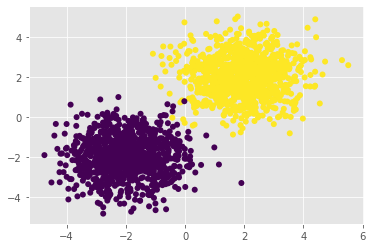

In [4]:
# Generate some data
N = 1000

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y]) # one-hot encoding Y

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

### Network Architecture

Try architecture that will perform `logistic regression` first, then try something else. 

In [5]:
criterion = MSECriterion()

net = Sequential()
net.add(Linear(2, 10))
net.add(ReLU())
net.add(Linear(10, 2))
net.add(SoftMax())

print(net)

Linear 2 -> 10
ReLU
Linear 10 -> 2
SoftMax



### Some Hyperparameters
At first, try using the whole dataset as batch and make sure that loss reduces at each step. Then reduce batch size and examine results.

Play with number of epochs and learning rate.

Recall that **number of epochs** indicates how many times we see the data fully during the training process. By seeing the data fully we mean seeing all data examples placed within the batches. Imagine we have 1000 data samples, the batch size is 100. In that case we will cover the whole data with 10 batches. So in each epoch we will have 10 forward and backward passes each time feeding the network with one batch consisting of 100 data samples. If we define the batch size = 80, we will have 12 runs of 80 data samples while 13th run will feed the network only the resting 40 data samples (12 * 80 = 960, 1000 - 960 = 40).

In [6]:
n_epoch = 10
batch_size = 1000
lr = 1e-1

### Batch Generator

Google to understand how python's `generator` objet differs from iterator.


In [7]:
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

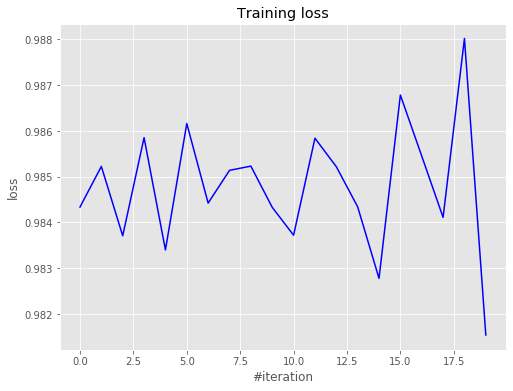

Current loss: 0.981540


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward Pass
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward Pass
        bp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, bp)
        
        # Update weights
        sgd(net.getParameters(), 
            net.getGradParameters(),
            lr)
           
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

### Fetching the Dataset

In [448]:
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r', allow_pickle=True) as data:
        train_images = data['X']
        train_labels = data['y']
else:
    mnist = fetch_openml("mnist_784")
    train_images, train_labels = mnist.data, mnist.target
    np.savez('mnist.npz', X=train_images, y=train_labels)

### One-hot Encoding the Labels
For one-hot encoding you can use sklearn's `OneHotEncoder` class.

In [449]:
enc = OneHotEncoder()
one_hot_y = enc.fit_transform(train_labels.reshape(-1, 1)).todense()

/home/levon/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Train Test Splitting

In [450]:
X_train = train_images[:10000]/255
y_train = one_hot_y[:10000]
y_train = np.array(y_train)
X_val = train_images[10000:15000]/255
y_val = one_hot_y[10000:15000]
y_val = np.array(y_val)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)


X_train (10000, 784)
y_train (10000, 10)
X_val (5000, 784)
y_val (5000, 10)


### Training a NN

You can use the codes above.

In [462]:
# TODO: Define Hyperparameters here
n_epoch = 22
batch_size = 1024
lr = 0.00005

In [463]:
# TODO: Define NN architecture 
criterion = CrossEntropyCriterion()

net = Sequential()
net.add(Linear(784, 1000))
net.add(Tanh())
net.add(Linear(1000, 10))

net.add(SoftMax())

In [464]:
def sgd(x, dx, lr, state={}):
    """
    Implementation of sgd with storing old gradients in state. Google to understand how setdefault works.

    :param lr:     learning rate, default value is 0.1
    :param state:  empty dictionary to store gradients throught the update process
    """
    
    state.setdefault('old_grad', {})
    
    i = 0 
    for current_layer_x, current_layer_dx in zip(x,dx): 
        for current_x, current_dx in zip(current_layer_x,current_layer_dx):
            current_old_grad = state['old_grad'].setdefault(i, np.zeros_like(current_dx))
            current_old_grad = current_old_grad + current_dx
            state['old_grad'][i] = current_old_grad
            if current_old_grad.shape[0] == 1:
                current_x = cur_x.reshape(current_old_grad.shape)
            np.add(current_x, lr*(-current_old_grad), out=current_x)
            i += 1   

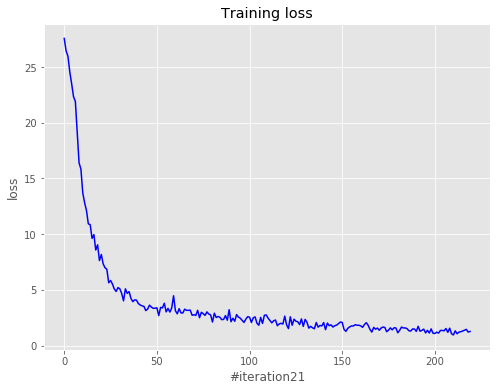

Current loss: 1.261628


In [465]:
# TODO: Training Proccess
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        net.zeroGradParameters()
        
        # Forward Pass
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward Pass
        bp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, bp)
        
        # Update weights
        sgd(net.getParameters(), 
            net.getGradParameters(),
            lr)
           
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration{0}".format(i))
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

### Evaluate on Test Dataset

In [466]:
net.evaluate()
pred = net.forward(X_val)
pred = np.argmax(pred, axis=1)
accuracy_score(pred, np.argmax(y_val, axis=1))

0.8896